# Introduction

In this assignment you will be given a series of tasks about using the library `power-grid-model`. The tasks include:

1. Load input
2. Data validation for large datasets
3. Columnar data memory usage
4. Selective output
5. Numpy tips
    1. Views vs copies
    2. Other tips
    3. PGM related recommendations
6. Graph operations 
7. Topology caching
6. N 1 Scenario-Batch-Calculation

The input data are CSV files in the `data/` folder:
* `node.csv`
* `line.csv`
* `source.csv`
* `sym_load.csv`


# Preparation

First import everything we need for this workshop:

In [62]:
import time
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from power_grid_model import (
    PowerGridModel,
    CalculationType,
    CalculationMethod,
    ComponentType,
    DatasetType,
    initialize_array,
    attribute_dtype,
    attribute_empty_value,
    power_grid_meta_data
)

from power_grid_model.validation import assert_valid_input_data, assert_valid_batch_data

from power_grid_model_ds import Grid, PowerGridModelInterface
from power_grid_model_ds.enums import NodeType
from power_grid_model_ds.visualizer import visualize

# For memory monitoring
import psutil
import gc
import os
from collections import Counter

# Utilities

Let's define a timer class to easily benchmark the calculations:

In [ ]:
class Timer:
    def __init__(self, name: str):
        self.name = name
        self.start = None

    def __enter__(self):
        self.start = time.perf_counter()

    def __exit__(self, *args):
        print(
            f"Execution time for {self.name} is {(time.perf_counter() - self.start):0.6f} s"
        )

Now let's create a memory usage monitor to track memory consumption during calculations:

In [ ]:
import psutil
import gc
import os


class MemoryMonitor:
    def __init__(self, name: str):
        self.name = name
        self.process = psutil.Process(os.getpid())
        self.start_memory = None
        self.peak_memory = None

    def __enter__(self):
        # Force garbage collection to get a clean starting point
        gc.collect()
        # Get initial memory usage
        self.start_memory = (
            self.process.memory_info().rss / 1024 / 1024
        )  # Convert to MB
        self.peak_memory = self.start_memory
        return self

    def __exit__(self, *args):
        # Force garbage collection before final measurement
        gc.collect()
        # Get final memory usage
        end_memory = self.process.memory_info().rss / 1024 / 1024  # Convert to MB
        memory_diff = end_memory - self.start_memory
        peak_diff = self.peak_memory - self.start_memory

        print(f"Memory usage for {self.name}:")
        print(f"  Start: {self.start_memory:.2f} MB")
        print(f"  End: {end_memory:.2f} MB")
        print(f"  Net change: {memory_diff:+.2f} MB")
        print(f"  Peak increase: {peak_diff:+.2f} MB")

    def update_peak(self):
        """Manually update peak memory usage during execution"""
        current_memory = self.process.memory_info().rss / 1024 / 1024
        if current_memory > self.peak_memory:
            self.peak_memory = current_memory

You can also combine both Timer and MemoryMonitor for comprehensive performance analysis:

In [ ]:
class PerformanceMonitor:
    """Combined timer and memory monitor for comprehensive performance analysis"""

    def __init__(self, name: str):
        self.name = name
        self.timer = Timer(name)
        self.memory_monitor = MemoryMonitor(name)

    def __enter__(self):
        self.timer.__enter__()
        self.memory_monitor.__enter__()
        return self

    def __exit__(self, *args):
        self.timer.__exit__(*args)
        self.memory_monitor.__exit__(*args)
        print(f"--- End of {self.name} performance report ---\n")

In [ ]:
class PerfLogger:
    """Simple in-memory performance logger that stores records in a pandas DataFrame."""

    def __init__(self):
        self.records = []

    def log(
        self,
        name: str,
        start_time: float,
        end_time: float,
        start_mem: float,
        end_mem: float,
        peak_mem: float,
    ):
        self.records.append(
            {
                "name": name,
                "start_time": start_time,
                "end_time": end_time,
                "duration_s": end_time - start_time,
                "start_mem_mb": start_mem,
                "end_mem_mb": end_mem,
                "net_mem_change_mb": end_mem - start_mem,
                "peak_mem_mb": peak_mem,
                "peak_increase_mb": peak_mem - start_mem,
            }
        )

    def to_dataframe(self) -> pd.DataFrame:
        return pd.DataFrame(self.records)


class LoggedPerformanceMonitor(PerformanceMonitor):
    """A PerformanceMonitor that logs results into a PerfLogger."""

    def __init__(self, name: str, logger: PerfLogger):
        super().__init__(name)
        self.logger = logger
        self._start_time = None
        self._start_mem = None

    def __enter__(self):
        # start timer and memory monitor
        self._start_time = time.perf_counter()
        self._start_mem = self.memory_monitor.process.memory_info().rss / 1024 / 1024
        self.timer.__enter__()
        self.memory_monitor.__enter__()
        return self

    def __exit__(self, *args):
        # capture end values and delegate to base
        end_time = time.perf_counter()
        self.timer.__exit__(*args)
        self.memory_monitor.__exit__(*args)
        end_mem = self.memory_monitor.process.memory_info().rss / 1024 / 1024
        peak_mem = self.memory_monitor.peak_memory
        # log the record
        self.logger.log(
            self.name, self._start_time, end_time, self._start_mem, end_mem, peak_mem
        )


# Polling-backed variant to capture short-lived peaks
import threading
import time as _time


class PollingLoggedPerformanceMonitor(LoggedPerformanceMonitor):
    """Poll process memory on a short interval in a background thread to catch transient peaks."""

    def __init__(self, name: str, logger: PerfLogger, poll_interval: float = 0.01):
        super().__init__(name, logger)
        self.poll_interval = poll_interval
        self._stop_event = threading.Event()
        self._thread = None

    def _poll(self):
        proc = self.memory_monitor.process
        while not self._stop_event.is_set():
            cur = proc.memory_info().rss / 1024 / 1024
            if cur > self.memory_monitor.peak_memory:
                self.memory_monitor.peak_memory = cur
            _time.sleep(self.poll_interval)

    def __enter__(self):
        # start base enter first to initialize memory_monitor
        super().__enter__()
        self._stop_event.clear()
        self._thread = threading.Thread(target=self._poll, daemon=True)
        self._thread.start()
        return self

    def __exit__(self, *args):
        self._stop_event.set()
        if self._thread is not None:
            self._thread.join()
        return super().__exit__(*args)


The following examples demonstrate how to use the Timer, MemoryMonitor, and PerformanceMonitor classes:

In [6]:
# Example 1: Using Timer only
a = np.random.rand(1000000)
b = np.random.rand(1000000)
with Timer("Add Operation"):
    c = a + b

Execution time for Add Operation is 0.008699 s


In [7]:
# Example 2: Using MemoryMonitor only
with MemoryMonitor("Large Array Creation"):
    large_array = np.random.rand(5000000)  # ~40MB array
    processed_array = large_array * 2 + 1
    del large_array  # Explicitly delete to free memory

Memory usage for Large Array Creation:
  Start: 188.52 MB
  End: 227.30 MB
  Net change: +38.78 MB
  Peak increase: +0.00 MB


In [8]:
# Example 3: Using PerformanceMonitor for comprehensive analysis
with PerformanceMonitor("Matrix Operations"):
    # Create large matrices
    matrix_a = np.random.rand(2000, 2000)
    matrix_b = np.random.rand(2000, 2000)

    # Perform memory-intensive operations
    result = np.dot(matrix_a, matrix_b)
    eigenvalues = np.linalg.eigvals(result[:100, :100])  # Small subset for speed

    # Clean up
    del matrix_a, matrix_b, result

Execution time for Matrix Operations is 0.199182 s
Memory usage for Matrix Operations:
  Start: 227.30 MB
  End: 240.82 MB
  Net change: +13.52 MB
  Peak increase: +0.00 MB
--- End of Matrix Operations performance report ---



In [9]:
# Example 4: Demonstrate transient peak memory increase
with MemoryMonitor("Transient Peak Example") as mm:
    # Start with a small allocation
    a = np.random.rand(1000000)
    mm.update_peak()  # record current memory as peak so far

    # Create a transient large allocation that should raise peak
    temp = np.random.rand(8000000)  # transient large array
    mm.update_peak()  # update peak after transient allocation

    # Use the temporary array briefly
    s = temp.sum()

    # Remove the temporary allocation and force GC
    del temp
    gc.collect()

    # Final small operation
    a = a * 2
    del a

# The MemoryMonitor should report a peak increase above the start memory.

Memory usage for Transient Peak Example:
  Start: 240.82 MB
  End: 248.26 MB
  Net change: +7.44 MB
  Peak increase: +60.81 MB


In [10]:
# Usage example: poll-backed logger to reliably capture transient peak
perf_logger = PerfLogger()
with PollingLoggedPerformanceMonitor(
    "Polled Transient Peak", perf_logger, poll_interval=0.005
):
    temp = np.random.rand(8000000)
    s = temp.sum()
    del temp
    gc.collect()

# Convert logs to DataFrame and display
perf_df = perf_logger.to_dataframe()
print(perf_df.to_string(index=False))

Execution time for Polled Transient Peak is 0.177470 s
Memory usage for Polled Transient Peak:
  Start: 248.26 MB
  End: 248.58 MB
  Net change: +0.32 MB
  Peak increase: +61.04 MB
                 name   start_time     end_time  duration_s  start_mem_mb  end_mem_mb  net_mem_change_mb  peak_mem_mb  peak_increase_mb
Polled Transient Peak 39863.123998 39863.301627    0.177629    248.257812  248.578125           0.320312   309.296875         61.039062


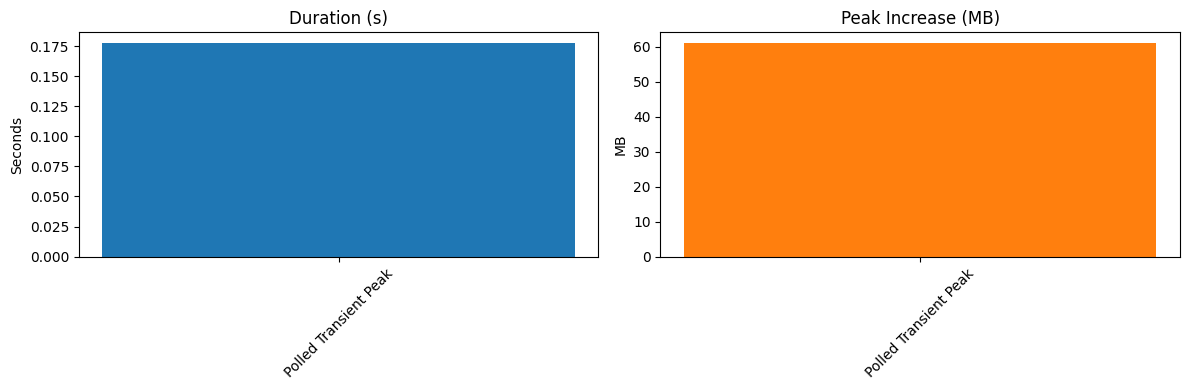

In [11]:
# Plotting: visualize duration and peak increase
import matplotlib.pyplot as plt

# If perf_df doesn't exist (run the previous logging cell), recreate from logger
try:
    perf_df
except NameError:
    perf_df = perf_logger.to_dataframe()

if perf_df.empty:
    print("No records to plot")
else:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Duration bar chart
    axes[0].bar(perf_df["name"], perf_df["duration_s"], color="tab:blue")
    axes[0].set_title("Duration (s)")
    axes[0].set_ylabel("Seconds")
    axes[0].tick_params(axis="x", rotation=45)

    # Peak increase bar chart
    axes[1].bar(perf_df["name"], perf_df["peak_increase_mb"], color="tab:orange")
    axes[1].set_title("Peak Increase (MB)")
    axes[1].set_ylabel("MB")
    axes[1].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()


In [12]:
def print_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"Current memory usage: {mem_info.rss / 1024 / 1024:.2f} MB")


def print_memory_used_by_object(object):
    print(f"{object.__sizeof__() / 1024 / 1024} MB")


def print_memory_used_by_dict(dictionary):
    print(
        f"{sum(object.__sizeof__() / 1024 / 1024 for object in dictionary.values())} MB"
    )


def print_memory_used_by_array(array: np.ndarray):
    print(f"{array.nbytes / 1024 / 1024} MB")


print_memory_usage()
print_memory_used_by_object([1] * 1000)
print_memory_used_by_object(
    {"a": [1] * 1000}
)  # This is because dictionary stores only references
print_memory_used_by_dict({"a": [1] * 1000})
print_memory_used_by_array(np.random.rand(1000, 1000))

Current memory usage: 251.70 MB
0.00766754150390625 MB
0.00016021728515625 MB
0.00766754150390625 MB
7.62939453125 MB


# Topology Data

In [27]:
def load_input_data() -> Dict[str, np.ndarray]:
    input_data = {}
    for component in [
        ComponentType.node,
        ComponentType.line,
        ComponentType.source,
        ComponentType.sym_load,
    ]:
        # Use pandas to read CSV data
        df = pd.read_csv(f"data/{component.value}.csv")

        # Initialize array
        input_data[component] = initialize_array(DatasetType.input, component, len(df))

        # Fill the attributes
        for attr, values in df.items():
            input_data[component][attr] = values

        # Print some debug info
        print(f"{component:9s}: {len(input_data[component]):4d}")

    return input_data


input_data = load_input_data()


ComponentType.node: 2001
ComponentType.line: 2000
ComponentType.source:    1
ComponentType.sym_load: 2000


In [28]:
model = PowerGridModel(input_data=input_data)

# Timeseries load profiles

In [ ]:
# Generate random load profile oh hourly data
n_timestamps = 24 * 7
dti = pd.date_range("2022-01-01", periods=n_timestamps, freq="h")
n_loads = len(input_data[ComponentType.sym_load])
load_id = input_data[ComponentType.sym_load]["id"]
load_p = input_data[ComponentType.sym_load]["p_specified"]
profile = np.tile(load_p, (n_timestamps, 1)) + 5e5 * np.random.randn(
    n_timestamps, n_loads
)
df_load_profile = pd.DataFrame(profile, columns=load_id, index=dti)

## PGM numpy arrays (Row based)

In [32]:
# Initialize an empty load profile
load_profile_row_based = initialize_array(
    DatasetType.update, ComponentType.sym_load, df_load_profile.shape
)

load_profile_row_based["id"] = df_load_profile.columns.to_numpy()
load_profile_row_based["p_specified"] = df_load_profile.to_numpy()
load_profile_row_based["q_specified"] = 0.0

# Construct the update data
update_data = {ComponentType.sym_load: load_profile_row_based}

print(load_profile_row_based.__sizeof__() / 1024 / 1024)  # in MB
print(load_profile_row_based.nbytes / 1024 / 1024)  # strictly data without overhead

7.6905517578125
7.6904296875


In [33]:
# Run Newton Raphson power flow (this may take a minute...)
with Timer("Batch Calculation using Newton-Raphson row based data"):
    output_data = model.calculate_power_flow(
        update_data=update_data, calculation_method=CalculationMethod.newton_raphson
    )

print(sum(arr.__sizeof__() / 1024 / 1024 for arr in output_data.values()))

Execution time for Batch Calculation using Newton-Raphson row based data is 0.160462 s
56.412353515625


### Columnar data format

In [36]:
load_profile_columnar = df_load_profile.to_numpy(
    dtype=attribute_dtype(DatasetType.update, ComponentType.sym_load, "p_specified"),
    copy=False,
    na_value=attribute_empty_value(
        DatasetType.update, ComponentType.sym_load, "p_specified"
    ),
)

# Construct the update data
update_data_columnar = {ComponentType.sym_load: {"p_specified": load_profile_columnar}}

print(load_profile_columnar.nbytes / 1024 / 1024)  # in MB

2.5634765625


Skipping ids is possible under certain conditions

In [39]:
with Timer("Batch Calculation using Newton-Raphson columnar data"):
    output_data = model.calculate_power_flow(
        update_data=update_data_columnar,
        calculation_method=CalculationMethod.newton_raphson,
    )

Execution time for Batch Calculation using Newton-Raphson columnar data is 0.155125 s


### Selective Output

Via output_component_types

In [41]:
with Timer("Batch Calculation using Newton-Raphson columnar data"):
    output_data_selective = model.calculate_power_flow(
        update_data=update_data_columnar,
        calculation_method=CalculationMethod.newton_raphson,
        output_component_types={ComponentType.line: ["loading"]},
    )

print(
    f"output_data_selective contains following: \n"
    f"Keys: {output_data_selective.keys()}. \n"
    f"Attributes: {output_data_selective[ComponentType.line].keys()}"
)
print(output_data_selective[ComponentType.line]["loading"].__sizeof__() / 1024 / 1024)

Execution time for Batch Calculation using Newton-Raphson columnar data is 0.136163 s
output_data_selective contains following: 
Keys: dict_keys([<ComponentType.line: 'line'>]). 
Attributes: dict_keys(['loading'])
2.5635986328125


#### Clear memory

In [42]:
del load_profile_row_based
del output_data
del output_data_selective

# Multiple Timeseries

In [ ]:
# Generate random load profile oh hourly data
n_vehicles = 10000
vehicle_capacity_kwh = 60
n_vehicles_distributions = 10
ev_profile = pd.read_csv("data/ev_profile.csv").to_numpy()
n_ev_profiles = ev_profile.shape[1]
n_vehicle_each_load_node_distributions = np.random.multinomial(
    n=n_vehicles, pvals=np.ones(n_loads) / n_loads, size=n_vehicles_distributions
)
vehicles_profile_indptr = np.zeros((n_vehicles_distributions, n_loads + 1), dtype=int)
vehicles_profile_indptr[:, 1:] = np.cumsum(
    n_vehicle_each_load_node_distributions, axis=1
)

vehicles_profile_idx = np.random.randint(0, n_ev_profiles, n_vehicles)

# n_loads = len(input_data[ComponentType.sym_load])
# load_id = input_data[ComponentType.sym_load]["id"]
# load_p = input_data[ComponentType.sym_load]["p_specified"]
# choose_random_loads = np.random.randint(low=0, high=n_loads, size=10)
# scaled_random_load_profile = load_p[choose_random_loads] / np.sum(load_p[choose_random_loads], axis=0)

# profile = np.tile(scaled_random_load_profile, (n_scenarios, 1)) * vehicle_capacity_kwh + 1e3 * np.random.randn(n_scenarios, n_loads)
# dti = dti = pd.date_range("2022-01-01", periods=n_scenarios, freq="h")
# df_load_profile = pd.DataFrame(profile, columns=load_id, index=dti)

In [23]:
n_vehicle_each_load_node_distributions.ravel()

array([6, 5, 3, ..., 6, 6, 4], shape=(20000,))

In [24]:
np.random.multinomial(n=n_vehicles, pvals=np.ones(n_ev_profiles) / n_ev_profiles)

array([ 986, 1018, 1033,  988,  977,  965, 1027, 1019, 1038,  949])

In [25]:
n_vehicle_to_profile_distributer = np.random.multinomial(
    n=n_vehicle_each_load_node_distributions.ravel(),
    pvals=np.ones(n_ev_profiles) / n_ev_profiles,
)

cumulative_sum = 0
result = np.zeros((n_timestamps, n_vehicles_distributions))
for i in range(n_vehicles_distributions):
    this_node_n_vehicles_idx = (
        cumulative_sum + n_vehicle_each_load_node_distributions[i]
    )
    result[:, i] = np.sum(
        ev_profile[:, vehicles_profile_idx[cumulative_sum:this_node_n_vehicles_idx]],
        axis=1,
    )
    cumulative_sum = this_node_n_vehicles_idx

TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
x = ev_profile[:, vehicles_profile_idx]

x.nbytes / 1024 / 1024
# del x

668.2586669921875

In [ ]:
sum_func = lambda x: np.sum(
    ev_profile[:, vehicles_profile_idx[vehicles_profile_indptr[x : x + 1]]], axis=1
)
x = sum_func(vehicles_profile_idx)
# vfunc = np.vectorize(squarer)
# result = vfunc(sum_func)

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
x

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [21.,  7., 14., ...,  7.,  0.,  7.],
       [14.,  7.,  7., ...,  7.,  0.,  7.],
       [14.,  7.,  7., ...,  7.,  0.,  0.]], shape=(8759, 10000))

In [ ]:
np.random.choice(n_loads, size=10)

array([1616,  828,  407, 1875, 1973, 1885, 1539,  347, 1741,  445])

In [ ]:
from matplotlib import pyplot as plt

plt.plot(n_vehicle_each_load_node)

NameError: name 'n_vehicle_each_load_node' is not defined

Sample array

In [ ]:
loads = initialize_array(DatasetType.update, ComponentType.sym_load, (1000, 10))
loads["id"] = range(10)
loads["status"] = 1
loads["p_specified"] = 1000
loads["q_specified"] = 1000


In [43]:
limit_related_output = {
    ComponentType.line: ["loading"],
    ComponentType.node: ["u_pu"],
    ComponentType.transformer: ["loading"],
}

# Side topics related to numpy


## Correct dtype


Use of initialize_array is recommended. 
However when you have a large dataset and you wish to translate the dtype into the one PGM uses, you can use  `initialize_array(dataset_type, component_type, empty_shape, empty=True)` or `dtype = power_grid_meta_data[dataset_type][component_type].dtype` to find the dtype of the row based data. You can use this to change to the appropriate type which is required by PGM.

For dtype of individual attribute which would be required in columnar data creation, you can use `attribute_dtype(data_type, component_type, attribute)`. The missing value can be filled by `attribute_empty_value(data_type, component_type, attribute)` 

Also check for contigious-ness. 

Check if a type-cast to this dtype creates a copy. Maybe such a copy is redundant.

In [ ]:
initialize_array(DatasetType.input, ComponentType.sym_load, 0, empty=True)
# power_grid_meta_data[DatasetType.input][ComponentType.sym_load].dtype

dtype([('id', '<i4'), ('node', '<i4'), ('status', 'i1'), ('type', 'i1'), ('p_specified', '<f8'), ('q_specified', '<f8')], align=True)

In [59]:
attribute_dtype(DatasetType.input, ComponentType.transformer, "sn")

dtype('float64')

All available attributes are visible via

In [102]:
initialize_array(DatasetType.input, ComponentType.sym_load, 0, empty=True).dtype.names

('id', 'node', 'status', 'type', 'p_specified', 'q_specified')

## Views vs copies

Check numpy documentation for when certain functions or features create a view or copy. 

* Views simplify assignment of values
* Uneccesary copies here are the first you can aim to eliminate to improve overall performance.


https://numpy.org/doc/stable/user/basics.copies.html


Checking if view or copy

if `array.base is None` -> copy; else -> view


In [ ]:
import numpy as np
x = np.arange(9)
x
y = x.reshape(3, 3)
y
y.base  # .reshape() creates a view
z = y[[2, 1]]
z
z.base is None  # advanced indexing creates a copy

True

## Garbage collection for views/copies

### Higher than required memory usage

In [ ]:
def calculate_and_give_first_50_loading(model, update_data):
    output_data = model.calculate_power_flow(
        update_data=update_data,
        calculation_method=CalculationMethod.newton_raphson,
        output_component_types=limit_related_output,
    )
    return output_data[ComponentType.line]["loading"][:50]


first_50_loading = calculate_and_give_first_50_loading(model, update_data)
print(f"Shape of returned array: {first_50_loading.shape}")
print_memory_used_by_array(first_50_loading)
print(f"Actual shape of memory: {first_50_loading.base.shape}")
print_memory_used_by_array(first_50_loading.base)

Shape of returned array: (50, 2000)
0.762939453125 MB
Actual shape of memory: (168, 2000)
2.5634765625 MB


### Right Way to return values

In [ ]:
def calculate_and_give_first_50_loading(model, update_data):
    output_data = model.calculate_power_flow(
        update_data=update_data,
        calculation_method=CalculationMethod.newton_raphson,
        output_component_types=limit_related_output,
    )
    return output_data[ComponentType.line]["loading"][:50].copy()


first_50_loading = calculate_and_give_first_50_loading(model, update_data)
print(f"Shape of returned array: {first_50_loading.shape}")
print_memory_used_by_array(first_50_loading)
assert first_50_loading.base is None

Shape of returned array: (50, 2000)
0.762939453125 MB


## Accessing and assigning to PGM arrays

In [128]:
loads = initialize_array(DatasetType.update, ComponentType.sym_load, (1000, 10))
loads[:] = (99, 1, 100.0, 100.0)

def copy_or_view(arr: np.ndarray) -> str:
    return "copy" if arr.base is None else "view"

In [130]:


print("Single batch all components: `loads[:, 0]` gets a :", copy_or_view(loads[:, 0]))
print("All batch single components: `loads[0, :]` gets a :", copy_or_view(loads[0, :]))
print("Sliced batch all components: `loads[:5, :]` gets a :", copy_or_view(loads[:5, :]))
print("Multiple batch via advanced indexing all components: `loads[[1,2,3], :]` gets a :", copy_or_view(loads[[1,2,3], :]))  # Advanced indexing creates a copy
print("All batch Multiple components via advanced indexing: `loads[:, [1,2,3]]` gets a :", copy_or_view(loads[:, [1,2,3]]))

Single batch all components: `loads[:, 0]` gets a : view
All batch single components: `loads[0, :]` gets a : view
Sliced batch all components: `loads[:5, :]` gets a : view
Multiple batch via advanced indexing all components: `loads[[1,2,3], :]` gets a : copy
All batch Multiple components via advanced indexing: `loads[:, [1,2,3]]` gets a : view


### Attribute access

Attribute access has similar behavior

In [131]:
print("Single batch all components: `loads['p_specified']` gets a :", copy_or_view(loads["p_specified"]))
print("Single batch all components: `loads['p_specified'][:,0]` gets a :", copy_or_view(loads["p_specified"][:, 0]))
print("Single batch all components: `loads['p_specified'][0, :]` gets a :", copy_or_view(loads["p_specified"][0, :]))
print("Sliced batch all components: `loads['p_specified'][:5, :]` gets a :", copy_or_view(loads["p_specified"][:5, :]))
print("Single batch all components: `loads['p_specified'][[1, 2, 3], :]` gets a :", copy_or_view(loads["p_specified"][[1, 2, 3], :]))
print("Single batch all components: `loads['p_specified'][:, [1, 2, 3]]` gets a :", copy_or_view(loads["p_specified"][:, [1, 2, 3]]))

Single batch all components: `loads['p_specified']` gets a : view
Single batch all components: `loads['p_specified'][:,0]` gets a : view
Single batch all components: `loads['p_specified'][0, :]` gets a : view
Sliced batch all components: `loads['p_specified'][:5, :]` gets a : view
Single batch all components: `loads['p_specified'][[1, 2, 3], :]` gets a : copy
Single batch all components: `loads['p_specified'][:, [1, 2, 3]]` gets a : view


Multi field indexing

In [136]:
print("Multiple attributes: `loads[['p_specified', 'q_specified']][:, [1, 2, 3]]` gets a :", copy_or_view(loads[["p_specified", "q_specified"]]))

Multiple attributes: `loads[['p_specified', 'q_specified']][:, [1, 2, 3]]` gets a : view


A common source of confusion is when dealing with numpy arrays view and copy variables look the same. 

View related variables modify the original array whereas a copy related variable does not modify the original array

In [143]:

y = loads["p_specified"][:, [7, 8, 9]]
loads["p_specified"][:, [7, 8, 9]] = 123456
print(y)

[[1.00000e+02 1.00000e+02 1.00000e+02]
 [1.23456e+05 1.23456e+05 1.23456e+05]
 [1.23456e+05 1.23456e+05 1.23456e+05]
 ...
 [1.00000e+02 1.00000e+02 1.00000e+02]
 [1.00000e+02 1.00000e+02 1.00000e+02]
 [1.00000e+02 1.00000e+02 1.00000e+02]]


In [142]:
x = loads["p_specified"][[1, 2, 3], :]
loads["p_specified"][[1, 2, 3], :] = 123456
print(x)


[[100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]]


### Assignment via tuples

In [148]:
example_loads = initialize_array(DatasetType.input, ComponentType.asym_load, (10, 5))
example_loads["p_specified"] = 1000
example_loads["p_specified"] = [[1000], [1000], [1000], [1000], [1000]]
# ('id', 'node', 'status', 'type', 'p_specified', 'q_specified')
example_loads[:, 0] = (1, 2, 1, 0, 123, 0)
example_loads[:] = (1, 2, 1, 0, 123, 0)
example_loads[:2]


array([[(1, 2, 1, 0, [123., 123., 123.], [0., 0., 0.]),
        (1, 2, 1, 0, [123., 123., 123.], [0., 0., 0.]),
        (1, 2, 1, 0, [123., 123., 123.], [0., 0., 0.]),
        (1, 2, 1, 0, [123., 123., 123.], [0., 0., 0.]),
        (1, 2, 1, 0, [123., 123., 123.], [0., 0., 0.])],
       [(1, 2, 1, 0, [123., 123., 123.], [0., 0., 0.]),
        (1, 2, 1, 0, [123., 123., 123.], [0., 0., 0.]),
        (1, 2, 1, 0, [123., 123., 123.], [0., 0., 0.]),
        (1, 2, 1, 0, [123., 123., 123.], [0., 0., 0.]),
        (1, 2, 1, 0, [123., 123., 123.], [0., 0., 0.])]],
      dtype={'names': ['id', 'node', 'status', 'type', 'p_specified', 'q_specified'], 'formats': ['<i4', '<i4', 'i1', 'i1', ('<f8', (3,)), ('<f8', (3,))], 'offsets': [0, 4, 8, 9, 16, 40], 'itemsize': 64, 'aligned': True})

# Designing PGM scenarios

## Large Timeseries

Use columnar data for P and Q specified

## Contingency analysis

For unequal sets use linear data + pointers

# Achieving control operations

# Validating large batch data

Since the validator for large batch dataset is expensive, we can choose to validate only some part of data

np.int32(0)

In [ ]:
core_interface = PowerGridModelInterface(input_data=input_data)
grid = core_interface.create_grid_from_input_data()
grid.node.node_type[0] = NodeType.SUBSTATION_NODE

grid.get_downstream_nodes(1)

grid.get_nearest_substation_node(10)
# print(grid.graphs.active_graph.get_connected(0))

# Find all paths between node 1 and node 10
print(grid.graphs.active_graph.get_all_paths(1, 10))

print(grid.graphs.active_graph.get_shortest_path(1, 10))

print(len(grid.graphs.active_graph.get_components()))

print(len(grid.graphs.active_graph.get_connected(node_id=1)))

print(len(grid.graphs.active_graph.get_connected(node_id=0, nodes_to_ignore=[1, 2])))


[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 9)
1
2000
1990


# Visualize

In [ ]:
visualize(grid)

In [ ]:
# Lines with most most number of dependent nodes
contingency_count = 5

all_pairs = []
for node in grid.node.id:
    paths = grid.graphs.active_graph.get_all_paths(node, grid.source.node[0])
    for path in paths:
        all_pairs += [(path[idx + 1], path[idx]) for idx in range(len(path) - 1)]


counts = Counter(all_pairs)
top_5_branches = counts.most_common(5)
from_nodes = [i[0][0] for i in top_5_branches]
to_nodes = [i[0][1] for i in top_5_branches]


In [ ]:
# grid.node.node_type[0] = 0
# grid.node.filter(5)
line_id = grid.line.filter(from_node=from_nodes, to_node=to_nodes, mode_="AND").id

In [ ]:
combos_contingencies = np.eye(contingency_count, dtype=np.uint8)
combos_contingencies_timestamps = np.tile(combos_contingencies, (1, n_timestamps))
combos_contingencies_timestamps_reshaped = combos_contingencies_timestamps.reshape(
    -1, contingency_count
)
# Worst case for PGM
# combos_contingencies_timestamps = combos_contingencies_timestamps.reshape(contingency_count, n_timestamps*contingency_count)

line_update = initialize_array(
    DatasetType.update,
    ComponentType.line,
    (contingency_count * n_timestamps, contingency_count),
)
line_update["id"] = line_id
line_update["from_status"] = 1 - combos_contingencies_timestamps_reshaped
line_update["to_status"] = 1 - combos_contingencies_timestamps_reshaped

In [ ]:
load_profile_combined = initialize_array(
    DatasetType.update,
    ComponentType.sym_load,
    (contingency_count * df_load_profile.shape[0], df_load_profile.shape[1]),
)
# load_profile["id"] = df_load_profile.columns.to_numpy()
load_profile_combined["p_specified"] = np.tile(
    load_profile_columnar, (contingency_count, 1)
)
load_profile_combined["q_specified"] = 0.0

update_data_combined = {
    ComponentType.line: line_update,
    ComponentType.sym_load: load_profile_combined,
}

with Timer("Batch Calculation with contingencies and load profiles"):
    output_data_combined = model.calculate_power_flow(
        update_data=update_data_combined,
        calculation_method=CalculationMethod.newton_raphson,
        output_component_types={ComponentType.line: ["loading"]},
    )

Execution time for Batch Calculation with contingencies and load profiles is 1.154605 s
Execution time for Batch Calculation with contingencies and load profiles all output is 1.308957 s


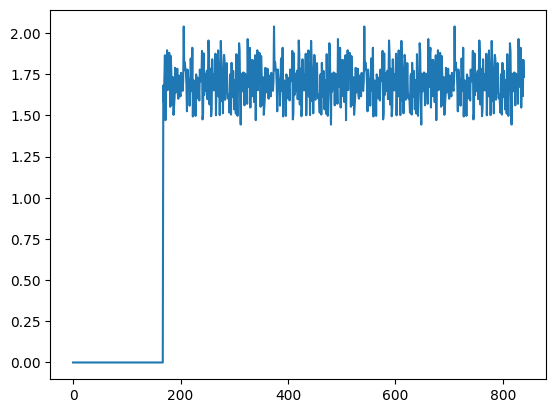

In [419]:
plt.plot(output_data_combined[ComponentType.line]["loading"][:, 0])